# Kernel spectral matched filter (KSMF) for hyperspectral target detection

#### Make sure both HDR files (subset_data100517.hdr &subset_data100517) are in ./data/ directory

<a href="#section1">1. HSI Data Loading & Pre-processing</a><br>
<a href="#section1.1" style="margin-left:20px">1.1. Load/Preprocess Data </a><br>
<a href="#section1.2" style="margin-left:20px">1.2. ROI Visualization - RGB Channels (436 X 449) </a><br>
<a href="#section1.3" style="margin-left:20px">1.3. ROI Ground Truth - RGB Channels (436 X 449) </a><br>
<a href="#section1.4" style="margin-left:20px">1.4. Background/Target Data With & Without MNF </a><br>

<a href="#section2">2. Matched Filter Detector (MFD) </a><br>
<a href="#section2.1" style="margin-left:20px">2.1. MFD without MNF </a><br>
<a href="#section2.2" style="margin-left:20px">2.2. MFD with MNF </a><br>

<a href="#section3">3. Kernel Spectral Match Filter (KSMF) </a><br>
<a href="#section3.1" style="margin-left:20px">3.1. Common Helper Functions </a><br>

<a href="#section4">4. KSMF (Gaussian Kernel)</a><br>
<a href="#section4.1" style="margin-left:20px">4.1. KSMF (Gaussian) Without MNF </a><br>
<a href="#section4.2" style="margin-left:20px">4.2. KSMF (Gaussian) with MNF </a><br>

<a href="#section5">5. KSMF (Polynomial Kernel)</a><br>
<a href="#section5.1" style="margin-left:20px">5.1. KSMF (Polynomial) Without MNF </a><br>
<a href="#section5.2" style="margin-left:20px">5.2. KSMF (Polynomial) with MNF </a><br>

<a href="#section6">6. KSMF (Spectral Angle Kernel)</a><br>
<a href="#section6.1" style="margin-left:20px">6.1. KSMF (Spectral Angle) Without MNF </a><br>
<a href="#section6.2" style="margin-left:20px">6.2. KSMF (Spectral Angle) with MNF </a><br>

<a href="#section7">7. Combined Plot</a><br>

<a href="#section8">8. ROC</a><br>

In [5]:
import pickle as pkl
import numpy as np
import random
import sympy

import spectral.io.envi as envi
from spectral import *

import pysptools.noise as ns

from sklearn import cluster, datasets, mixture
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.datasets import make_spd_matrix
from scipy.stats import multivariate_normal

from PIL import Image
from sklearn.metrics import roc_curve

from joblib import Parallel, delayed
from joblib import parallel_backend

from matplotlib import pyplot as plt
plt.rcParams["axes.grid"] = False

import warnings
warnings.filterwarnings("ignore")

<a id="section1"></a>
# 1.  HSI Data Loading & Pre-processing

<a id="section1.1"></a>
## 1.1. Load & Preprocess Data

### MNF transform is done on line 6 & 7 below to getthe MNF version of  ROI (ROI_MNF)

In [6]:
ROI = envi.open('./data/subset_data100517.hdr', './data/subset_data100517')

# ROI_MNF = envi.open('./data/Subset_data_MNF.hdr', './data/Subset_data_MNF')

# getting MNF version
mnf = ns.MNF()
ROI_MNF = mnf.apply(ROI[:,:,:])

print("ROI Shape:", ROI.shape)
print("ROI MNF Shape:", ROI_MNF.shape)

# wavelength: Red ~ 669, Green ~ 549, Blue ~ 474 
rgb_bands = (32, 20, 12)

target_pixels = [[222, 22], [222,23], [222,24], [222,25], [223,26],
                 [265,8], [265,17], [264,18], 
                 [265,32], [268, 32], [270,32], [268,29], [266,14], # x
                 [118,326], [121, 322], [125, 352], # x
                 [121,328], [122,340], 
                 [249, 366], [252,375], 
                 [322, 272], [342,293],
                 [384,102], [421,60], [422,63],
                 [326,258],
                 [338, 274],
                 [353, 290],
                 [317, 247]]

## Without MNF
target_spectrums = np.zeros((len(target_pixels), ROI.shape[2]))
for i in range(len(target_pixels)):
    target_spectrums[i,:] = ROI[target_pixels[i][0], target_pixels[i][1], :]
print(target_spectrums.shape)
avg_target_spectrum = np.sum(target_spectrums, axis=0)/len(target_pixels)
avg_target_spectrum = avg_target_spectrum.reshape(1,-1)
print(avg_target_spectrum.shape)
# target_spectrums = np.concatenate([target_spectrums, avg_target_spectrum], axis=0)
print(target_spectrums.shape)
print("---------")

## With MNF
target_spectrums_MNF = np.zeros((len(target_pixels), ROI_MNF.shape[2]))
for i in range(len(target_pixels)):
    target_spectrums_MNF[i,:] = ROI_MNF[target_pixels[i][0], target_pixels[i][1], :]
print(target_spectrums_MNF.shape)
avg_target_spectrum_MNF = np.sum(target_spectrums_MNF, axis=0)/len(target_pixels)
avg_target_spectrum_MNF = avg_target_spectrum_MNF.reshape(1,-1)
print(avg_target_spectrum_MNF.shape)
# target_spectrums_MNF = np.concatenate([target_spectrums_MNF, avg_target_spectrum_MNF], axis=0)
print(target_spectrums_MNF.shape)

ROI Shape: (436, 449, 187)
ROI MNF Shape: (436, 449, 187)
(29, 187)
(1, 187)
(29, 187)
---------
(29, 187)
(1, 187)
(29, 187)


<a id="section1.2"></a>
## 1.2. ROI Visualization - RGB Channels (436 x 449)
#### Orange pixels are oil spills

ROI_RGB Shape: (436, 449, 3)


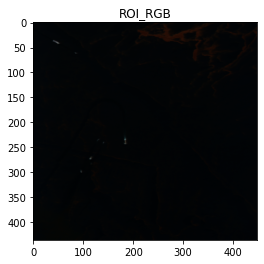

In [7]:
ROI_RGB = ROI[:,:,rgb_bands]
print("ROI_RGB Shape:", ROI_RGB.shape)
  
plt.imshow(ROI_RGB)
plt.title("ROI_RGB")
plt.savefig("./pics/ROI_RGB.png")

<a id="section1.3"></a>
## 1.3.  ROI Ground Truth Visualization - RGB Channels (436 x 449)

### Creating the o/1 label for Orange fixels for oil spill & background pixels

GT_RGB  Shape: (436, 449, 3)


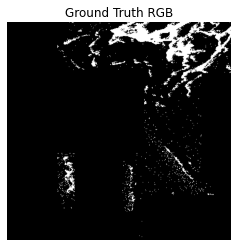

In [8]:
GT_RGB = np.zeros((ROI.shape[0], ROI.shape[1], 3))

for i in range(GT_RGB.shape[0]):
    for j in range(GT_RGB.shape[1]):
        
        # Using all spectral bands
        pixel_spectrum = ROI[i,j,:].reshape(1, -1)
        pixel_dist = [np.sqrt(np.sum(target_spectrums[i,:] - pixel_spectrum)**2)
                for i in range(target_spectrums.shape[0])]
        
        min_dist_target_spectrum = min(pixel_dist)
        
#         print(min_dist_target_spectrum)

        if min_dist_target_spectrum >= 3e-1:
            GT_RGB[i,j,:] = 1    
            
print("GT_RGB  Shape:", GT_RGB.shape)  


for i in range(0,436):
    for j in range(0,101):
        GT_RGB[i,j,:] = 0
        
for i in range(96,262):
    for j in range(0,275):
        GT_RGB[i,j,:] = 0        

for i in range(346,436):
    for j in range(272,449):
        GT_RGB[i,j,:] = 0  

for i in range(256,436):
    for j in range(136,231):
        GT_RGB[i,j,:] = 0 
        
for i in range(380,436):
    for j in range(100,264):
        GT_RGB[i,j,:] = 0 

for i in range(102,321):
    for j in range(390,449):
        GT_RGB[i,j,:] = 0 
        
plt.axis('off')
plt.imshow(GT_RGB)
plt.title("Ground Truth RGB")
plt.savefig("./pics/GT_RGB.png", bbox_inches='tight', transparent=True, pad_inches=0)

<a id="section1.4"></a>
## 1.4.  Background/Target Data - With & Without MNF

### Using k-means clustering to select 300 representative pixels for background & target each

In [7]:
# Using k-means clustering to reduce data sample size
background, target = [], []
background_MNF, target_MNF = [], []

for i in range(GT_RGB.shape[0]):
    for j in range(GT_RGB.shape[1]):
        
        if sum(GT_RGB[i,j,:]) == 0.0:
            background.append(ROI[i, j, :].reshape(-1,1))
            background_MNF.append(ROI_MNF[i, j, :].reshape(-1,1))
        else:
            target.append(ROI[i, j, :].reshape(-1,1))
            target_MNF.append(ROI_MNF[i, j, :].reshape(-1,1))             

            
#### Without MNF ################
print("Starting Without MNF")
background = np.array(background)
background = background.reshape(background.shape[0], background.shape[1])
print("background Pixels Shape:", background.shape)

kmeans_background = KMeans(n_clusters=300, random_state=0).fit(background)
centroids_background = kmeans_background.cluster_centers_
print("Background Centroids Shape:", centroids_background.shape)

target = np.array(target)
target = target.reshape(target.shape[0], target.shape[1])
print("Target Pixels Shape:", target.shape)

kmeans_target = KMeans(n_clusters=300, random_state=0).fit(target)
centroids_target = kmeans_target.cluster_centers_
print("Target Centroids Shape:", centroids_target.shape)

# independent targets needed for K(X,Y) & K(Y,Y) calculation later
_, inds = sympy.Matrix(centroids_target).T.rref()
independent_targets = centroids_target[np.array(inds)]
print("Independent Target Shape", independent_targets.shape)
#######################################

print("-------------")


#### Without MNF ################
print("Starting With MNF")
background_MNF = np.array(background_MNF)
background_MNF = background_MNF.reshape(background_MNF.shape[0], background_MNF.shape[1])
print("background_MNF Pixels Shape:", background_MNF.shape)

kmeans_background_MNF = KMeans(n_clusters=300, random_state=0).fit(background_MNF)
centroids_background_MNF = kmeans_background_MNF.cluster_centers_
print("Background_MNF Centroids Shape:", centroids_background_MNF.shape)

target_MNF = np.array(target_MNF)
target_MNF = target_MNF.reshape(target_MNF.shape[0], target_MNF.shape[1])
print("Target_MNF Pixels Shape:", target_MNF.shape)

kmeans_target_MNF = KMeans(n_clusters=300, random_state=0).fit(target_MNF)
centroids_target_MNF = kmeans_target_MNF.cluster_centers_
print("Target_MNF Centroids Shape:", centroids_target_MNF.shape)

# independent targets needed for K(X,Y) & K(Y,Y) calculation later
_, inds = sympy.Matrix(centroids_target_MNF).T.rref()
independent_targets_MNF = centroids_target_MNF[np.array(inds)]
print("Independent Target MNF Shape", independent_targets_MNF.shape)
#######################################


# Save to reload directly later if needed (without MNF)
with open("./kernel_data/centroids_background.pkl","wb") as f:
    pkl.dump(centroids_background, f)
    
with open("./kernel_data/centroids_target.pkl","wb") as f:
    pkl.dump(centroids_target, f)
    
with open("./kernel_data/background.pkl","wb") as f:
    pkl.dump(background, f)
    
with open("./kernel_data/target.pkl","wb") as f:
    pkl.dump(target, f)
    
with open("./kernel_data/independent_targets.pkl","wb") as f:
    pkl.dump(independent_targets, f)
    
    
# Save to reload directly later if needed (with MNF)
with open("./kernel_data/centroids_background_MNF.pkl","wb") as f:
    pkl.dump(centroids_background_MNF, f)
    
with open("./kernel_data/centroids_target_MNF.pkl","wb") as f:
    pkl.dump(centroids_target_MNF, f)
    
with open("./kernel_data/background_MNF.pkl","wb") as f:
    pkl.dump(background_MNF, f)
    
with open("./kernel_data/target_MNF.pkl","wb") as f:
    pkl.dump(target_MNF, f)
    
with open("./kernel_data/independent_targets_MNF.pkl","wb") as f:
    pkl.dump(independent_targets_MNF, f)    

background Pixels Shape: (184805, 187)
Background Centroids Shape: (300, 187)
Target Pixels Shape: (10959, 187)
Target Centroids Shape: (300, 187)
Independent Target Shape (187, 187)
-------------
Starting With MNF
background_MNF Pixels Shape: (184805, 187)
Background_MNF Centroids Shape: (300, 187)
Target_MNF Pixels Shape: (10959, 187)
Target_MNF Centroids Shape: (300, 187)
Independent Target MNF Shape (187, 187)


In [5]:
## Reload saved data if necessary to avoid step 1.4 above
# without MNF
with open("./kernel_data/centroids_background.pkl","rb") as f:
    centroids_background = pkl.load(f)
    
with open("./kernel_data/centroids_target.pkl","rb") as f:
    centroids_target = pkl.load(f)
    
with open("./kernel_data/background.pkl","rb") as f:
    background = pkl.load(f)
    
with open("./kernel_data/target.pkl","rb") as f:
    target = pkl.load(f)
    
with open("./kernel_data/independent_targets.pkl","rb") as f:
    independent_targets = pkl.load(f)

    
# with MNF
with open("./kernel_data/centroids_background_MNF.pkl","rb") as f:
    centroids_background_MNF = pkl.load(f)
    
with open("./kernel_data/centroids_target_MNF.pkl","rb") as f:
    centroids_target_MNF = pkl.load(f)
    
with open("./kernel_data/background_MNF.pkl","rb") as f:
    background_MNF = pkl.load(f)
    
with open("./kernel_data/target_MNF.pkl","rb") as f:
    target_MNF = pkl.load(f)
    
with open("./kernel_data/independent_targets_MNF.pkl","rb") as f:
    independent_targets_MNF = pkl.load(f)
    
print("Without MNF")    
print("background Pixels Shape:", background.shape)
print("Background Centroids Shape:", centroids_background.shape)
print("Target Centroids Shape:", centroids_target.shape)
print("Independent Target Shape", independent_targets.shape)
print("-----")

print("With MNF")
print("background_MNF Pixels Shape:", background_MNF.shape)
print("Background_MNF Centroids Shape:", centroids_background_MNF.shape)
print("Target_MNF Centroids Shape:", centroids_target_MNF.shape)
print("Independent Target MNF Shape", independent_targets_MNF.shape)

Without MNF
background Pixels Shape: (184805, 187)
Background Centroids Shape: (300, 187)
Target Centroids Shape: (300, 187)
Independent Target Shape (187, 187)
-----
With MNF
background_MNF Pixels Shape: (184805, 187)
Background_MNF Centroids Shape: (300, 187)
Target_MNF Centroids Shape: (300, 187)
Independent Target MNF Shape (187, 187)


<a id="section2"></a>
## 2. MFD

<a id="section2.1"></a>
## 2.1.  MFD Without MNF

In [9]:
# read the (436*449=195764 pixels)
X = []
for i in range(ROI.shape[0]):
    for j in range(ROI.shape[1]):
        X.append(ROI[i,j,:])

X = np.array(X) # eqn 2 in paper
print("X Shape:", X.shape)

# k_means clustering of background pixels
background_pixels = []
for i in range(ROI.shape[0]):
    for j in range(ROI.shape[1]):
        current_pixel_spectrum = ROI[i, j, :].reshape(-1,1)
        
        # eucleadean distance betwwen current spectral band and taregt spectrum band of the orange pixel
        target_distance = np.sqrt(np.sum(current_pixel_spectrum - avg_target_spectrum)**2)
        
        if target_distance > 1: # we used threshold of 5 in sec 1
            background_pixels.append(current_pixel_spectrum)

background_pixels = np.array(background_pixels)
background_pixels = background_pixels.reshape(background_pixels.shape[0], background_pixels.shape[1])
print("Background Pixels Shape:", background_pixels.shape)

kmeans = KMeans(n_clusters=187, random_state=0).fit(background_pixels)
centroids = kmeans.cluster_centers_
print("Centroids Shape:", centroids.shape)

mean_background = np.mean(centroids, axis=0)
mean_background = mean_background.reshape(1,-1)
print("Mean Background Shape:", mean_background.shape)

covariance_background = np.cov(centroids)
print("Background Covariance Shape:", covariance_background.shape)

# use pseudo inverse if normal inverse matrix doesn't exist
inv_covariance_background = np.linalg.inv(covariance_background) # normal matrix inverse
# inv_covariance_background = np.linalg.pinv(covariance_background) # pesudo inverse

print("Background Covariance Inverse Shape:", inv_covariance_background.shape)

with open("./kernel_data/centroids.pkl","wb") as f:
    pkl.dump(centroids, f)

X Shape: (195764, 1, 1, 187)
Background Pixels Shape: (194798, 187)
Centroids Shape: (187, 187)
Mean Background Shape: (1, 187)
Background Covariance Shape: (187, 187)
Background Covariance Inverse Shape: (187, 187)


ROI - accuracy: 0.66, precision:0.58, recall:0.09, f1:0.16


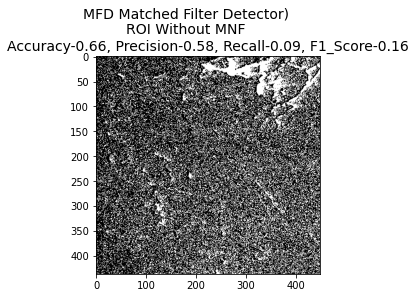

In [18]:
predictions_MFD = np.zeros((ROI.shape[0],ROI.shape[1],3))
y_MFD = []

PREDS_MFD, GT_LABELS_MFD = [], []

for i in range(ROI.shape[0]):
    for j in range(ROI.shape[1]):
        current_pixel_spectrum = ROI[i,j,:].reshape(1, -1)
        
        x1 = avg_target_spectrum - mean_background
        x2 = current_pixel_spectrum - mean_background
        
#         y = (((x1).dot(R_hat_inv)).dot(x2.T))/(((x1).dot(R_hat_inv)).dot(x1.T)) # eqn 10 of paper
        y = (((x1).dot(inv_covariance_background)).dot(x2.T))/(((x1).dot(inv_covariance_background)).dot(x1.T))
        
        y = y[0][0] # y is an array so extract value
        
#         print(y)
        y_MFD.append(y)
        
        if y < .1: # using this threshold value (.8) after trying various other values
            predictions_MFD[i,j,:] = 1

        # Save 0/1 labels for sklearn's various accuracy & metric calculation below   
        gt = sum(GT_RGB[i,j,:])
        if gt == 0.0:
            GT_LABELS_MFD.append(0)
        else:
            GT_LABELS_MFD.append(1)

        pred = sum(predictions_MFD[i,j,:])            
        if pred == 0.0:
            PREDS_MFD.append(0)
        else:
            PREDS_MFD.append(1)
                
# let's save these so as to directlt load later rather than rerun the code
with open("./kernel_data/predictions_MFD.pkl","wb") as f:
    pkl.dump(predictions_MFD,f)
with open("./kernel_data/y_MFD.pkl","wb") as f:
    pkl.dump(y_MFD,f)
with open("./kernel_data/PREDS_MFD.pkl","wb") as f:
    pkl.dump(PREDS_MFD,f)
with open("./kernel_data/GT_LABELS_MFD.pkl","wb") as f:
    pkl.dump(GT_LABELS_MFD,f)
    
# various sklearn's metric
accuracy_MFD = accuracy_score(PREDS_MFD, GT_LABELS_MFD)
precision_MFD = precision_score(PREDS_MFD, GT_LABELS_MFD)
recall_MFD = recall_score(PREDS_MFD, GT_LABELS_MFD)
f1_MFD = f1_score(PREDS_MFD, GT_LABELS_MFD)
print("ROI - accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".\
      format(accuracy_MFD, precision_MFD, recall_MFD, f1_MFD))

plt.imshow(predictions_MFD)
plt.title("MFD Matched Filter Detector)\
          \nROI Without MNF\
          \nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}"\
          .format(accuracy_MFD, precision_MFD, recall_MFD, f1_MFD), size=14)

plt.savefig("./pics/ROI_MFD.png")

<a id="section2.2"></a>
## 2.2.  MFD With MNF

In [30]:
# read the (436*449=195764 pixels)
X_MNF = []
for i in range(ROI_MNF.shape[0]):
    for j in range(ROI_MNF.shape[1]):
        X_MNF.append(ROI_MNF[i,j,:])

X_MNF = np.array(X_MNF) # eqn 2 in paper
print("X_MNF Shape:", X_MNF.shape)

# k_means clustering of background pixels
background_pixels_MNF = []
for i in range(ROI_MNF.shape[0]):
    for j in range(ROI_MNF.shape[1]):
        current_pixel_spectrum = ROI_MNF[i, j, :].reshape(-1,1)
        
        # eucleadean distance betwwen current spectral band and taregt spectrum band of the orange pixel
        target_distance = np.sqrt(np.sum(current_pixel_spectrum - avg_target_spectrum_MNF)**2)
        
        if target_distance > 1: # we used threshold of 5 in sec 1
            background_pixels_MNF.append(current_pixel_spectrum)

background_pixels_MNF = np.array(background_pixels_MNF)
background_pixels_MNF = background_pixels_MNF.reshape(background_pixels_MNF.shape[0], background_pixels_MNF.shape[1])
print("MNF - Background Pixels Shape:", background_pixels_MNF.shape)

kmeans = KMeans(n_clusters=187, random_state=0).fit(background_pixels_MNF)
centroids_MNF = kmeans.cluster_centers_
print("centroids_MNF Shape:", centroids_MNF.shape)

mean_background_MNF = np.mean(centroids_MNF, axis=0)
mean_background_MNF = mean_background_MNF.reshape(1,-1)
print("MNF - Mean Background Shape:", mean_background_MNF.shape)

covariance_background_MNF = np.cov(centroids_MNF)
print("MNF - Background Covariance Shape:", covariance_background_MNF.shape)

# use pseudo inverse if normal inverse matrix doesn't exist
inv_covariance_background_MNF = np.linalg.inv(covariance_background_MNF) # normal matrix inverse
# inv_covariance_background = np.linalg.pinv(covariance_background) # pesudo inverse

print("MNF - Background Covariance Inverse Shape:", inv_covariance_background_MNF.shape)

with open("./kernel_data/centroids_MNF.pkl","wb") as f:
    pkl.dump(centroids_MNF, f)

X_MNF Shape: (195764, 187)
MNF - Background Pixels Shape: (195754, 187)
centroids_MNF Shape: (187, 187)
MNF - Mean Background Shape: (1, 187)
MNF - Background Covariance Shape: (187, 187)
MNF - Background Covariance Inverse Shape: (187, 187)


ROI - accuracy: 0.97, precision:0.56, recall:0.86, f1:0.68


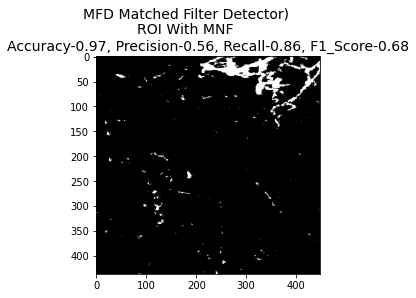

In [24]:
predictions_MFD_MNF = np.zeros((ROI_MNF.shape[0],ROI_MNF.shape[1],3))
y_MFD_MNF = []

PREDS_MFD_MNF, GT_LABELS_MFD_MNF = [], []

for i in range(ROI_MNF.shape[0]):
    for j in range(ROI_MNF.shape[1]):
        current_pixel_spectrum = ROI_MNF[i,j,:].reshape(1, -1)
        
        x1 = avg_target_spectrum - mean_background_MNF
        x2 = current_pixel_spectrum - mean_background_MNF
        
#         y = (((x1).dot(R_hat_inv)).dot(x2.T))/(((x1).dot(R_hat_inv)).dot(x1.T)) # eqn 10 of paper
        y = (((x1).dot(inv_covariance_background_MNF)).dot(x2.T))/(((x1).dot(inv_covariance_background_MNF)).dot(x1.T))
        
        y = y[0][0] # y is an array so extract value
        
#         print(y)
        
        y_MFD_MNF.append(y)
        
        if y < .6: # using this threshold value (.8) after trying various other values
            predictions_MFD_MNF[i,j,:] = 1
            
        # save y value for thresholding for ROC curve later
        y_MFD_MNF.append(y)

        # Save 0/1 labels for sklearn's various accuracy & metric calculation below   
        gt = sum(GT_RGB[i,j,:])
        if gt == 0.0:
            GT_LABELS_MFD_MNF.append(0)
        else:
            GT_LABELS_MFD_MNF.append(1)

        pred = sum(predictions_MFD_MNF[i,j,:])            
        if pred == 0.0:
            PREDS_MFD_MNF.append(0)
        else:
            PREDS_MFD_MNF.append(1)
                
# let's save these so as to directlt load later rather than rerun the code
with open("./kernel_data/predictions_MFD_MNF.pkl","wb") as f:
    pkl.dump(predictions_MFD_MNF,f)
with open("./kernel_data/y_MFD_MNF.pkl","wb") as f:
    pkl.dump(y_MFD_MNF,f)
with open("./kernel_data/PREDS_MFD_MNF.pkl","wb") as f:
    pkl.dump(PREDS_MFD_MNF,f)
with open("./kernel_data/GT_LABELS_MFD_MNF.pkl","wb") as f:
    pkl.dump(GT_LABELS_MFD_MNF,f)
    
# various sklearn's metric
accuracy_MFD_MNF = accuracy_score(PREDS_MFD_MNF, GT_LABELS_MFD_MNF)
precision_MFD_MNF = precision_score(PREDS_MFD_MNF, GT_LABELS_MFD_MNF)
recall_MFD_MNF = recall_score(PREDS_MFD_MNF, GT_LABELS_MFD_MNF)
f1_MFD_MNF = f1_score(PREDS_MFD_MNF, GT_LABELS_MFD_MNF)
print("ROI - accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".\
      format(accuracy_MFD_MNF, precision_MFD_MNF, recall_MFD_MNF, f1_MFD_MNF))

plt.imshow(predictions_MFD_MNF)
plt.title("MFD Matched Filter Detector)\
          \nROI With MNF\
          \nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}"\
          .format(accuracy_MFD_MNF, precision_MFD_MNF, recall_MFD_MNF, f1_MFD_MNF), size=14)

plt.savefig("./pics/ROI_MFD_MNF.png")

<a id="section3"></a>
## 3  Kernel Spectral Match Filter (KSMF)

<a id="section3.1"></a>
## 3.1.  Helper Functions

In [5]:
## reload some data
with open("./kernel_data/centroids.pkl","rb") as f:
    centroids = pkl.load(f)
    
with open("./kernel_data/centroids_MNF.pkl","rb") as f:
    centroids_MNF = pkl.load(f)

    
##### Gaussian_Radial Basis Function (GRBF) kernel #####
# width of Gaussian RBF kernel, to be determined with trial & errors
c=1e5
# c=.08
def k_GRBF(x, y):                     
    norm= np.linalg.norm(x - y)
    return np.exp(-1*norm*norm/c)

###### Polynomial Kernel.#####
d= 5 #power parameter of polynomial kernel, tbd
theta= 1 #constant term for polynomial kernel, tbd

def k_poly(x,y):                        
    return np.power(np.dot(x,y.T)+theta, d)


##### Spectral angle_based kernel. #####
def k_spectral(x, y):        
    norm_x= np.linalg.norm(x)
    norm_y= np.linalg.norm(y)
    dot= x.dot(y.T)
    return dot/(norm_x*norm_y)


#####
# Kernel/Gram Matrix
def gram_matrix(kernel, centroids):
    K = np.zeros((centroids.shape[0], centroids.shape[0])) # K(X,X) the gram matrix
    for i in range(K.shape[0]):
        for j in range(K.shape[1]):
            K[i,j] = kernel(centroids[i,:].reshape(1,-1), centroids[j,:].reshape(1,-1))
    print("Kernel Matrix Shape:", K.shape)

    K_inv = np.linalg.pinv(K) # calculating pseudo inverse as normal inverse gave errors
    K_inv2 = K_inv**2 # K^-2 that's to be used in eqn 27 of paper
    print("K_inv2 Shape", K_inv2.shape)
    
    return K, K_inv, K_inv2

# function to calculate k_s or k_r or function (psi(s)*X.T) or (psi(r)*X.T) in eqn 24 & eqn 25 of [a[er]]
def ks_kr(kernel, centroids, spectrum_value):
#     k = []
#     for i in range(centroids.shape[0]):
#         k_ = kernel(spectrum_value, centroids[i].reshape(1,-1))
#         k.append(k_)
    
    k = [kernel(spectrum_value, centroids[i].reshape(1,-1)) for i in range(centroids.shape[0])]
    
    k = np.array(k).reshape(1,-1)
    
#     print("\t/*", k[0])
    return k

def KSMF(j, kernel, k_s, pixel_spectrum, K_inv2):
    
    k_r = ks_kr(kernel, centroids, pixel_spectrum.reshape(1, -1))
    y = ((k_s.dot(K_inv2)).dot(k_r.T))/((k_s.dot(K_inv2)).dot(k_s.T))       
    y = y[0][0]    
    
    return [j, y]

def KSMF_metrics(GT_RGB, roi, k_s, K_Inv2, kernel="gaussian", show_val=False, threshold_cond="gt"):
    
    # Generate predictions from KSMF method for ROI
    predictions_KSMF = np.zeros((roi.shape[0],roi.shape[1],3))
    y_KSMF = []
    PREDS_KSMF, GT_LABELS_KSMF = [], []
    
    if kernel=="gaussian":
        kernel_func = k_GRBF
    elif kernel=="polynomial":
        kernel_func = k_poly
    else:
        kernel_func = k_spectral
    
    for i in range(roi.shape[0]):
        with parallel_backend('threading', n_jobs=5):
            list_results = Parallel()(delayed(KSMF)(j, kernel_func, k_s, roi[i,j,:], K_Inv2) 
                                      for j in range(roi.shape[1]))
        list_results.sort(key = lambda x: x[0])
        
        for j in range(roi.shape[1]):
            y = list_results[j][1]
#             y = y[0][0]
            
            if show_val:
                print(y)

            if threshold_cond=="gt":
                if y >= ETA_THRESHOLD:
                    predictions_KSMF[i,j,:] = 0
                else:
                    predictions_KSMF[i,j,:] = 1
            else:
                if y <= ETA_THRESHOLD:
                    predictions_KSMF[i,j,:] = 0
                else:
                    predictions_KSMF[i,j,:] = 1
            
            # save y value for thresholding for ROC curve later
            y_KSMF.append(y)

            # Save 0/1 labels for sklearn's various accuracy & metric calculation below   
            gt = sum(GT_RGB[i,j,:])
            if gt == 0.0:
                GT_LABELS_KSMF.append(0)
            else:
                GT_LABELS_KSMF.append(1)

            pred = sum(predictions_KSMF[i,j,:])            
            if pred == 0.0:
                PREDS_KSMF.append(0)
            else:
                PREDS_KSMF.append(1)
                
    return predictions_KSMF, y_KSMF, PREDS_KSMF, GT_LABELS_KSMF

<a id="section4"></a>
## 4  KSMF (Gaussian Kernel)

<a id="section4.1"></a>
## 4.1.  KSMF (Gaussian Kernel) without MNF

In [44]:
k_s = ks_kr(k_GRBF, centroids, avg_target_spectrum) # eqn 24
print("k_s Shape:", k_s.shape)

K, K_inv, K_inv2 = gram_matrix(k_GRBF, centroids)

# SHOW_VAL = True
SHOW_VAL = False

INEQUALITY_COND = "gt"
# INEQUALITY_COND = "lt"

ETA_THRESHOLD = .6

predictions_KSMF_Gaussian, y_KSMF_Gaussian, PREDS_KSMF_Gaussian, GT_LABELS_KSMF_Gaussian = \
KSMF_metrics(GT_RGB, ROI, k_s, K_inv2, kernel="gaussian", show_val=SHOW_VAL, threshold_cond=INEQUALITY_COND)

# let's save these so as to directlt load later rather than rerun the code
with open("./kernel_data/predictions_KSMF_Gaussian.pkl","wb") as f:
    pkl.dump(predictions_KSMF_Gaussian, f)
with open("./kernel_data/y_KSMF_Gaussian.pkl","wb") as f:
    pkl.dump(y_KSMF_Gaussian, f)
with open("./kernel_data/PREDS_KSMF_Gaussian.pkl","wb") as f:
    pkl.dump(PREDS_KSMF_Gaussian, f)
with open("./kernel_data/GT_LABELS_KSMF_Gaussian.pkl","wb") as f:
    pkl.dump(GT_LABELS_KSMF_Gaussian, f)  

k_s Shape: (1, 187)
Kernel Matrix Shape: (187, 187)
K_inv2 Shape (187, 187)


ROI - accuracy: 0.92, precision:0.94, recall:0.41, f1:0.57


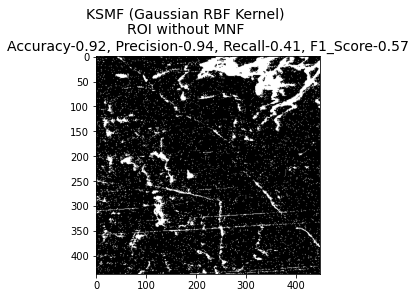

In [45]:
# let's save these so as to directlt load later rather than rerun the code
with open("./kernel_data/predictions_KSMF_Gaussian.pkl","rb") as f:
    predictions_KSMF_Gaussian = pkl.load(f)
with open("./kernel_data/y_KSMF_Gaussian.pkl","rb") as f:
    y_KSMF_Gaussian = pkl.load(f)
with open("./kernel_data/PREDS_KSMF_Gaussian.pkl","rb") as f:
    PREDS_KSMF_Gaussian = pkl.load(f)
with open("./kernel_data/GT_LABELS_KSMF_Gaussian.pkl","rb") as f:
    GT_LABELS_KSMF_Gaussian = pkl.load(f)

# various sklearn's metric
accuracy_KSMF_Gaussian = accuracy_score(PREDS_KSMF_Gaussian, GT_LABELS_KSMF_Gaussian)
precision_KSMF_Gaussian = precision_score(PREDS_KSMF_Gaussian, GT_LABELS_KSMF_Gaussian)
recall_KSMF_Gaussian = recall_score(PREDS_KSMF_Gaussian, GT_LABELS_KSMF_Gaussian)
f1_KSMF_Gaussian = f1_score(PREDS_KSMF_Gaussian, GT_LABELS_KSMF_Gaussian)
print("ROI - accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".\
      format(accuracy_KSMF_Gaussian, precision_KSMF_Gaussian, recall_KSMF_Gaussian, f1_KSMF_Gaussian))

plt.imshow(predictions_KSMF_Gaussian)
plt.title("KSMF (Gaussian RBF Kernel)\
          \nROI without MNF\
          \nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}"\
          .format(accuracy_KSMF_Gaussian, precision_KSMF_Gaussian, recall_KSMF_Gaussian, f1_KSMF_Gaussian), size=14)

plt.savefig("./pics/ROI_KSMF_Gaussian.png")

<a id="section4.2"></a>
## 4.2.  KASD (Gaussian Kernel) with MNF

In [7]:
k_s = ks_kr(k_GRBF, centroids_MNF, avg_target_spectrum_MNF) # eqn 24
print("k_s Shape:", k_s.shape)

K, K_inv, K_inv2 = gram_matrix(k_GRBF, centroids_MNF)

# SHOW_VAL = True
SHOW_VAL = False

# INEQUALITY_COND = "gt"
INEQUALITY_COND = "lt"

ETA_THRESHOLD = .1 # lt - nice
ETA_THRESHOLD = .07

predictions_KSMF_Gaussian_MNF, y_KSMF_Gaussian_MNF, PREDS_KSMF_Gaussian_MNF, GT_LABELS_KSMF_Gaussian_MNF = \
KSMF_metrics(GT_RGB, ROI_MNF, k_s, K_inv2, kernel="Gaussian", show_val=SHOW_VAL, threshold_cond=INEQUALITY_COND)

# let's save these so as to directlt load later rather than rerun the code
with open("./kernel_data/predictions_KSMF_Gaussian_MNF.pkl","wb") as f:
    pkl.dump(predictions_KSMF_Gaussian_MNF, f)
with open("./kernel_data/y_KSMF_Gaussian_MNF.pkl","wb") as f:
    pkl.dump(y_KSMF_Gaussian_MNF, f)
with open("./kernel_data/PREDS_KSMF_Gaussian_MNF.pkl","wb") as f:
    pkl.dump(PREDS_KSMF_Gaussian_MNF, f)
with open("./kernel_data/GT_LABELS_KSMF_Gaussian_MNF.pkl","wb") as f:
    pkl.dump(GT_LABELS_KSMF_Gaussian_MNF, f)  

k_s Shape: (1, 187)
Kernel Matrix Shape: (187, 187)
K_inv2 Shape (187, 187)


ROI - accuracy: 0.86, precision:0.71, recall:0.25, f1:0.37


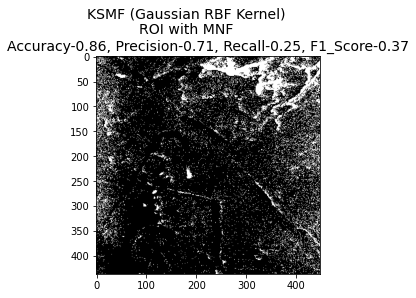

In [8]:
# reload & plot
with open("./kernel_data/predictions_KSMF_Gaussian_MNF.pkl","rb") as f:
    predictions_KSMF_Gaussian_MNF = pkl.load(f)
with open("./kernel_data/y_KSMF_Gaussian_MNF.pkl","rb") as f:
    y_KSMF_Gaussian_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KSMF_Gaussian_MNF.pkl","rb") as f:
    PREDS_KSMF_Gaussian_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KSMF_Gaussian_MNF.pkl","rb") as f:
    GT_LABELS_KSMF_Gaussian_MNF = pkl.load(f) 
    
# various sklearn's metric
accuracy_KSMF_Gaussian_MNF = accuracy_score(PREDS_KSMF_Gaussian_MNF, GT_LABELS_KSMF_Gaussian_MNF)
precision_KSMF_Gaussian_MNF = precision_score(PREDS_KSMF_Gaussian_MNF, GT_LABELS_KSMF_Gaussian_MNF)
recall_KSMF_Gaussian_MNF = recall_score(PREDS_KSMF_Gaussian_MNF, GT_LABELS_KSMF_Gaussian_MNF)
f1_KSMF_Gaussian_MNF = f1_score(PREDS_KSMF_Gaussian_MNF, GT_LABELS_KSMF_Gaussian_MNF)
print("ROI - accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".\
      format(accuracy_KSMF_Gaussian_MNF, precision_KSMF_Gaussian_MNF, recall_KSMF_Gaussian_MNF, f1_KSMF_Gaussian_MNF))

plt.imshow(predictions_KSMF_Gaussian_MNF)
plt.title("KSMF (Gaussian RBF Kernel)\
          \nROI with MNF\
          \nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}"\
          .format(accuracy_KSMF_Gaussian_MNF, precision_KSMF_Gaussian_MNF, recall_KSMF_Gaussian_MNF, f1_KSMF_Gaussian_MNF), size=14)

plt.savefig("./pics/ROI_KSMF_Gaussian_MNF.png")

<a id="section5"></a>
## 5.  KSMF (Polynomial Kernel)

<a id="section5.1"></a>
## 5.1.  KSMF (Polynomial) without MNF

In [11]:
k_s = ks_kr(k_poly, centroids, avg_target_spectrum) # eqn 24
print("k_s Shape:", k_s.shape)

K, K_inv, K_inv2 = gram_matrix(k_poly, centroids)

# SHOW_VAL = True
SHOW_VAL = False

# INEQUALITY_COND = "gt"
INEQUALITY_COND = "lt"

ETA_THRESHOLD = 1.5

predictions_KSMF_Polynomial, y_KSMF_Polynomial, PREDS_KSMF_Polynomial, GT_LABELS_KSMF_Polynomial = \
KSMF_metrics(GT_RGB, ROI, k_s, K_inv2, kernel="polynomial", show_val=SHOW_VAL, threshold_cond=INEQUALITY_COND)

# let's save these so as to directlt load later rather than rerun the code
with open("./kernel_data/predictions_KSMF_Polynomial.pkl","wb") as f:
    pkl.dump(predictions_KSMF_Polynomial, f)
with open("./kernel_data/y_KSMF_Polynomial.pkl","wb") as f:
    pkl.dump(y_KSMF_Polynomial, f)
with open("./kernel_data/PREDS_KSMF_Polynomial.pkl","wb") as f:
    pkl.dump(PREDS_KSMF_Polynomial, f)
with open("./kernel_data/GT_LABELS_KSMF_Polynomial.pkl","wb") as f:
    pkl.dump(GT_LABELS_KSMF_Polynomial, f)  

Background Kernel Matrix Shape: (300, 300)
K_Inv2 Shape (300, 300)
K_XY Shape: (300, 187)
Independent Target Kernel Matrix Shape: (187, 187)
K_T Shape: (187, 300)
mat shape: (187, 187)


ROI - accuracy: 0.97, precision:0.45, recall:0.91, f1:0.61


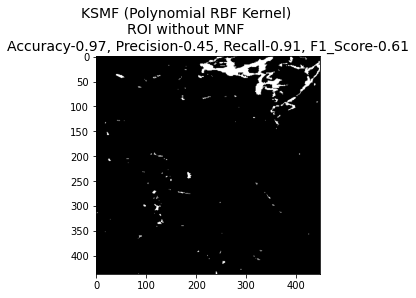

In [9]:
# let's save these so as to directlt load later rather than rerun the code
with open("./kernel_data/predictions_KSMF_Polynomial.pkl","rb") as f:
    predictions_KSMF_Polynomial = pkl.load(f)
with open("./kernel_data/y_KSMF_Polynomial.pkl","rb") as f:
    y_KSMF_Polynomial = pkl.load(f)
with open("./kernel_data/PREDS_KSMF_Polynomial.pkl","rb") as f:
    PREDS_KSMF_Polynomial = pkl.load(f)
with open("./kernel_data/GT_LABELS_KSMF_Polynomial.pkl","rb") as f:
    GT_LABELS_KSMF_Polynomial = pkl.load(f)

# various sklearn's metric
accuracy_KSMF_Polynomial = accuracy_score(PREDS_KSMF_Polynomial, GT_LABELS_KSMF_Polynomial)
precision_KSMF_Polynomial = precision_score(PREDS_KSMF_Polynomial, GT_LABELS_KSMF_Polynomial)
recall_KSMF_Polynomial = recall_score(PREDS_KSMF_Polynomial, GT_LABELS_KSMF_Polynomial)
f1_KSMF_Polynomial = f1_score(PREDS_KSMF_Polynomial, GT_LABELS_KSMF_Polynomial)
print("ROI - accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".\
      format(accuracy_KSMF_Polynomial, precision_KSMF_Polynomial, recall_KSMF_Polynomial, f1_KSMF_Polynomial))

plt.imshow(predictions_KSMF_Polynomial)
plt.title("KSMF (Polynomial RBF Kernel)\
          \nROI without MNF\
          \nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}"\
          .format(accuracy_KSMF_Polynomial, precision_KSMF_Polynomial, recall_KSMF_Polynomial, f1_KSMF_Polynomial), size=14)

plt.savefig("./pics/ROI_KSMF_Polynomial.png")

<a id="section5.2"></a>
## 5.2.  KSMF (Polynomial) with MNF

In [14]:
k_s = ks_kr(k_poly, centroids_MNF, avg_target_spectrum_MNF) # eqn 24
print("k_s Shape:", k_s.shape)

K, K_inv, K_inv2 = gram_matrix(k_poly, centroids_MNF)

SHOW_VAL = True
SHOW_VAL = False

INEQUALITY_COND = "gt"
# INEQUALITY_COND = "lt"

ETA_THRESHOLD = 1e-19 # LT
ETA_THRESHOLD = 1e-22 # LT

predictions_KSMF_Polynomial_MNF, y_KSMF_Polynomial_MNF, PREDS_KSMF_Polynomial_MNF, GT_LABELS_KSMF_Polynomial_MNF = \
KSMF_metrics(GT_RGB, ROI_MNF, k_s, K_inv2, kernel="polynomial", show_val=SHOW_VAL, threshold_cond=INEQUALITY_COND)

# let's save these so as to directlt load later rather than rerun the code
with open("./kernel_data/predictions_KSMF_Polynomial_MNF.pkl","wb") as f:
    pkl.dump(predictions_KSMF_Polynomial_MNF, f)
with open("./kernel_data/y_KSMF_Polynomial_MNF.pkl","wb") as f:
    pkl.dump(y_KSMF_Polynomial_MNF, f)
with open("./kernel_data/PREDS_KSMF_Polynomial_MNF.pkl","wb") as f:
    pkl.dump(PREDS_KSMF_Polynomial_MNF, f)
with open("./kernel_data/GT_LABELS_KSMF_Polynomial_MNF.pkl","wb") as f:
    pkl.dump(GT_LABELS_KSMF_Polynomial_MNF, f)  

Background Kernel Matrix Shape: (300, 300)
K_Inv2 Shape (300, 300)
K_XY Shape: (300, 187)
Independent Target Kernel Matrix Shape: (187, 187)
K_T Shape: (187, 300)
mat shape: (187, 187)


ROI - accuracy: 0.58, precision:0.84, recall:0.10, f1:0.18


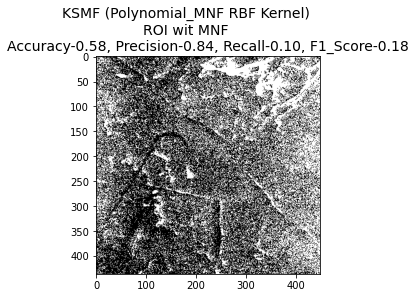

In [23]:
# let's save these so as to directlt load later rather than rerun the code
with open("./kernel_data/predictions_KSMF_Polynomial_MNF.pkl","rb") as f:
    predictions_KSMF_Polynomial_MNF = pkl.load(f)
with open("./kernel_data/y_KSMF_Polynomial_MNF.pkl","rb") as f:
    y_KSMF_Polynomial_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KSMF_Polynomial_MNF.pkl","rb") as f:
    PREDS_KSMF_Polynomial_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KSMF_Polynomial_MNF.pkl","rb") as f:
    GT_LABELS_KSMF_Polynomial_MNF = pkl.load(f)

# various sklearn's metric
accuracy_KSMF_Polynomial_MNF = accuracy_score(PREDS_KSMF_Polynomial_MNF, GT_LABELS_KSMF_Polynomial_MNF)
precision_KSMF_Polynomial_MNF = precision_score(PREDS_KSMF_Polynomial_MNF, GT_LABELS_KSMF_Polynomial_MNF)
recall_KSMF_Polynomial_MNF = recall_score(PREDS_KSMF_Polynomial_MNF, GT_LABELS_KSMF_Polynomial_MNF)
f1_KSMF_Polynomial_MNF = f1_score(PREDS_KSMF_Polynomial_MNF, GT_LABELS_KSMF_Polynomial_MNF)
print("ROI - accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".\
      format(accuracy_KSMF_Polynomial_MNF, precision_KSMF_Polynomial_MNF, recall_KSMF_Polynomial_MNF, f1_KSMF_Polynomial_MNF))

plt.imshow(predictions_KSMF_Polynomial_MNF)
plt.title("KSMF (Polynomial_MNF RBF Kernel)\
          \nROI wit MNF\
          \nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}"\
          .format(accuracy_KSMF_Polynomial_MNF, precision_KSMF_Polynomial_MNF, recall_KSMF_Polynomial_MNF, f1_KSMF_Polynomial_MNF), size=14)

plt.savefig("./pics/ROI_KSMF_Polynomial_MNF.png")

<a id="section6"></a>
## 6.  KSMF (Spectral Angle)

<a id="section6.1"></a>
## 6.1.  KSMF (Spectral Angle Kernel) without MNF

In [29]:
k_s = ks_kr(k_spectral, centroids, avg_target_spectrum) # eqn 24
print("k_s Shape:", k_s.shape)

K, K_inv, K_inv2 = gram_matrix(k_spectral, centroids)

# SHOW_VAL = True
SHOW_VAL = False

# INEQUALITY_COND = "gt"
# # INEQUALITY_COND = "lt"

# ETA_THRESHOLD = .6 # ROI - accuracy: 0.66, precision:0.27, recall:0.05, f1:0.08

INEQUALITY_COND = "gt"
# INEQUALITY_COND = "lt"

ETA_THRESHOLD = .85 # ROI - accuracy: 0.79, precision:0.16, recall:0.05, f1:0.08
ETA_THRESHOLD = .86

predictions_KSMF_Spectral, y_KSMF_Spectral, PREDS_KSMF_Spectral, GT_LABELS_KSMF_Spectral = \
KSMF_metrics(GT_RGB, ROI, k_s, K_inv2, kernel="spectral", show_val=SHOW_VAL, threshold_cond=INEQUALITY_COND)

# let's save these so as to directlt load later rather than rerun the code
with open("./kernel_data/predictions_KSMF_Spectral.pkl","wb") as f:
    pkl.dump(predictions_KSMF_Spectral, f)
with open("./kernel_data/y_KSMF_Spectral.pkl","wb") as f:
    pkl.dump(y_KSMF_Spectral, f)
with open("./kernel_data/PREDS_KSMF_Spectral.pkl","wb") as f:
    pkl.dump(PREDS_KSMF_Spectral, f)
with open("./kernel_data/GT_LABELS_KSMF_Spectral.pkl","wb") as f:
    pkl.dump(GT_LABELS_KSMF_Spectral, f)  

k_s Shape: (1, 187)
Kernel Matrix Shape: (187, 187)
K_inv2 Shape (187, 187)


ROI - accuracy: 0.75, precision:0.19, recall:0.05, f1:0.08


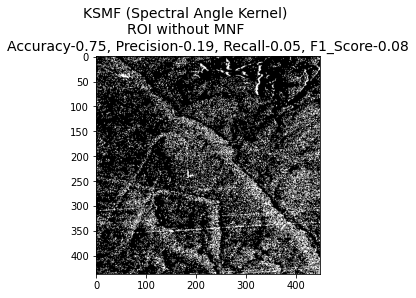

In [21]:
# reload & plot
with open("./kernel_data/predictions_KSMF_Spectral.pkl","rb") as f:
    predictions_KSMF_Spectral = pkl.load(f)
with open("./kernel_data/y_KSMF_Spectral.pkl","rb") as f:
    y_KSMF_Spectral = pkl.load(f)
with open("./kernel_data/PREDS_KSMF_Spectral.pkl","rb") as f:
    PREDS_KSMF_Spectral = pkl.load(f)
with open("./kernel_data/GT_LABELS_KSMF_Spectral.pkl","rb") as f:
    GT_LABELS_KSMF_Spectral = pkl.load(f)

# various sklearn's metric
accuracy_KSMF_Spectral = accuracy_score(PREDS_KSMF_Spectral, GT_LABELS_KSMF_Spectral)
precision_KSMF_Spectral = precision_score(PREDS_KSMF_Spectral, GT_LABELS_KSMF_Spectral)
recall_KSMF_Spectral = recall_score(PREDS_KSMF_Spectral, GT_LABELS_KSMF_Spectral)
f1_KSMF_Spectral = f1_score(PREDS_KSMF_Spectral, GT_LABELS_KSMF_Spectral)
print("ROI - accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".\
      format(accuracy_KSMF_Spectral, precision_KSMF_Spectral, recall_KSMF_Spectral, f1_KSMF_Spectral))

plt.imshow(predictions_KSMF_Spectral)
plt.title("KSMF (Spectral Angle Kernel)\
          \nROI without MNF\
          \nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}"\
          .format(accuracy_KSMF_Spectral, precision_KSMF_Spectral, recall_KSMF_Spectral, f1_KSMF_Spectral), size=14)

plt.savefig("./pics/ROI_KSMF_Spectral.png")

<a id="section6.2"></a>
## 6.2.  KSMF (Spectral Angle Kernel) with MNF

In [19]:
k_s = ks_kr(k_spectral, centroids_MNF, avg_target_spectrum_MNF) # eqn 24
print("k_s Shape:", k_s.shape)

K, K_inv, K_inv2 = gram_matrix(k_spectral, centroids_MNF)

SHOW_VAL = True
SHOW_VAL = False

INEQUALITY_COND = "gt"
# INEQUALITY_COND = "lt"

ETA_THRESHOLD = .25 # lt
ETA_THRESHOLD = .15 # ROI - accuracy: 0.46, precision:0.94, recall:0.09, f1:0.16
ETA_THRESHOLD = .08 # ROI - accuracy: 0.57, precision:0.93, recall:0.11, f1:0.20
ETA_THRESHOLD = .04

predictions_KSMF_Spectral_MNF, y_KSMF_Spectral_MNF, PREDS_KSMF_Spectral_MNF, GT_LABELS_KSMF_Spectral_MNF = \
KSMF_metrics(GT_RGB, ROI_MNF, k_s, K_inv2, kernel="spectral", show_val=SHOW_VAL, threshold_cond=INEQUALITY_COND)

# let's save these so as to directlt load later rather than rerun the code
with open("./kernel_data/predictions_KSMF_Spectral_MNF.pkl","wb") as f:
    pkl.dump(predictions_KSMF_Spectral_MNF, f)
with open("./kernel_data/y_KSMF_Spectral_MNF.pkl","wb") as f:
    pkl.dump(y_KSMF_Spectral_MNF, f)
with open("./kernel_data/PREDS_KSMF_Spectral_MNF.pkl","wb") as f:
    pkl.dump(PREDS_KSMF_Spectral_MNF, f)
with open("./kernel_data/GT_LABELS_KSMF_Spectral_MNF.pkl","wb") as f:
    pkl.dump(GT_LABELS_KSMF_Spectral_MNF, f)  

k_s Shape: (1, 187)
Kernel Matrix Shape: (187, 187)
K_inv2 Shape (187, 187)


ROI - accuracy: 0.69, precision:0.91, recall:0.14, f1:0.25


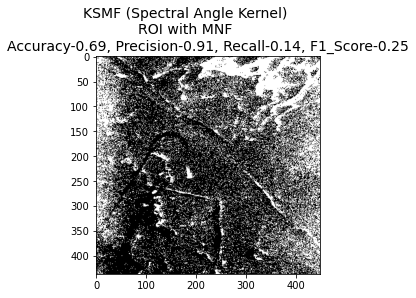

In [20]:
# reload & plot
with open("./kernel_data/predictions_KSMF_Spectral_MNF.pkl","rb") as f:
    predictions_KSMF_Spectral_MNF = pkl.load(f)
with open("./kernel_data/y_KSMF_Spectral_MNF.pkl","rb") as f:
    y_KSMF_Spectral_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KSMF_Spectral_MNF.pkl","rb") as f:
    PREDS_KSMF_Spectral_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KSMF_Spectral_MNF.pkl","rb") as f:
    GT_LABELS_KSMF_Spectral_MNF = pkl.load(f)

# various sklearn's metric
accuracy_KSMF_Spectral_MNF = accuracy_score(PREDS_KSMF_Spectral_MNF, GT_LABELS_KSMF_Spectral_MNF)
precision_KSMF_Spectral_MNF = precision_score(PREDS_KSMF_Spectral_MNF, GT_LABELS_KSMF_Spectral_MNF)
recall_KSMF_Spectral_MNF = recall_score(PREDS_KSMF_Spectral_MNF, GT_LABELS_KSMF_Spectral_MNF)
f1_KSMF_Spectral_MNF = f1_score(PREDS_KSMF_Spectral_MNF, GT_LABELS_KSMF_Spectral_MNF)
print("ROI - accuracy: {:.2f}, precision:{:.2f}, recall:{:.2f}, f1:{:.2f}".\
      format(accuracy_KSMF_Spectral_MNF, precision_KSMF_Spectral_MNF, recall_KSMF_Spectral_MNF, f1_KSMF_Spectral_MNF))

plt.imshow(predictions_KSMF_Spectral_MNF)
plt.title("KSMF (Spectral Angle Kernel)\
          \nROI with MNF\
          \nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}"\
          .format(accuracy_KSMF_Spectral_MNF, precision_KSMF_Spectral_MNF, recall_KSMF_Spectral_MNF, f1_KSMF_Spectral_MNF), size=14)

plt.savefig("./pics/ROI_KSMF_Spectral_MNF.png")

<a id="section7"></a>
## 7.  Combined Plot

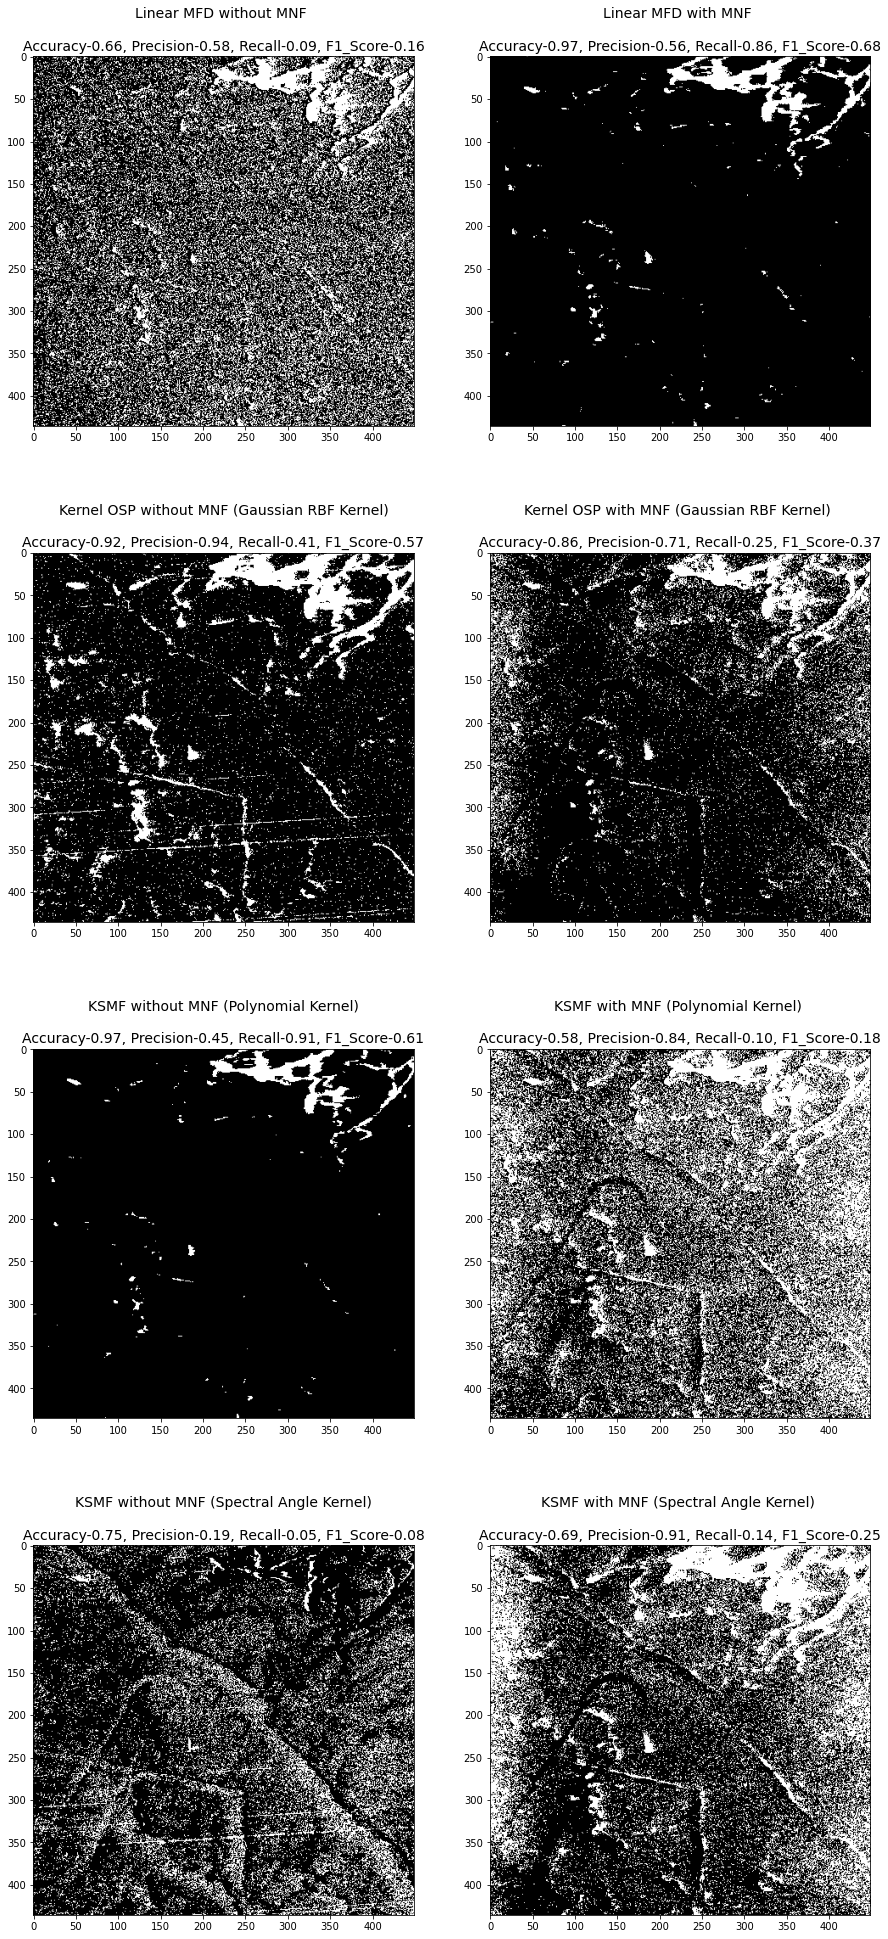

In [24]:
# plt.figure(figsize=(20,15))

plt.figure(figsize=(15,35))

###################################### Linear MFD ###########################################################
plt.subplot(421)
with open("./kernel_data/predictions_MFD.pkl","rb") as f:
    predictions_MFD = pkl.load(f)
with open("./kernel_data/PREDS_MFD.pkl","rb") as f:
    PREDS_MFD = pkl.load(f)
with open("./kernel_data/GT_LABELS_MFD.pkl","rb") as f:
    GT_LABELS_MFD = pkl.load(f)
    
accuracy = accuracy_score(PREDS_MFD, GT_LABELS_MFD)
precision = precision_score(PREDS_MFD, GT_LABELS_MFD)
recall = recall_score(PREDS_MFD, GT_LABELS_MFD)
f1 = f1_score(PREDS_MFD, GT_LABELS_MFD)

plt.imshow(predictions_MFD)
plt.title("Linear MFD without MNF \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)


plt.subplot(422)
with open("./kernel_data/predictions_MFD_MNF.pkl","rb") as f:
    predictions_MFD_MNF = pkl.load(f)
with open("./kernel_data/PREDS_MFD_MNF.pkl","rb") as f:
    PREDS_MFD_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_MFD_MNF.pkl","rb") as f:
    GT_LABELS_MFD_MNF = pkl.load(f)

accuracy = accuracy_score(PREDS_MFD_MNF, GT_LABELS_MFD_MNF)
precision = precision_score(PREDS_MFD_MNF, GT_LABELS_MFD_MNF)
recall = recall_score(PREDS_MFD_MNF, GT_LABELS_MFD_MNF)
f1 = f1_score(PREDS_MFD_MNF, GT_LABELS_MFD_MNF)

plt.imshow(predictions_MFD_MNF)
plt.title("Linear MFD with MNF \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)
#############################################################################################################
    
###################################### Gaussian RBF Kernel ###########################################################
plt.subplot(423)
with open("./kernel_data/predictions_KSMF_Gaussian.pkl","rb") as f:
    predictions_KSMF_Gaussian = pkl.load(f)
with open("./kernel_data/PREDS_KSMF_Gaussian.pkl","rb") as f:
    PREDS_KSMF_Gaussian = pkl.load(f)
with open("./kernel_data/GT_LABELS_KSMF_Gaussian.pkl","rb") as f:
    GT_LABELS_KSMF_Gaussian = pkl.load(f)
    
accuracy = accuracy_score(PREDS_KSMF_Gaussian, GT_LABELS_KSMF_Gaussian)
precision = precision_score(PREDS_KSMF_Gaussian, GT_LABELS_KSMF_Gaussian)
recall = recall_score(PREDS_KSMF_Gaussian, GT_LABELS_KSMF_Gaussian)
f1 = f1_score(PREDS_KSMF_Gaussian, GT_LABELS_KSMF_Gaussian)

plt.imshow(predictions_KSMF_Gaussian)
plt.title("\nKernel OSP without MNF (Gaussian RBF Kernel)\
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)


plt.subplot(424)
with open("./kernel_data/predictions_KSMF_Gaussian_MNF.pkl","rb") as f:
    predictions_KSMF_Gaussian_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KSMF_Gaussian_MNF.pkl","rb") as f:
    PREDS_KSMF_Gaussian_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KSMF_Gaussian_MNF.pkl","rb") as f:
    GT_LABELS_KSMF_Gaussian_MNF = pkl.load(f)
    
accuracy = accuracy_score(PREDS_KSMF_Gaussian_MNF, GT_LABELS_KSMF_Gaussian_MNF)
precision = precision_score(PREDS_KSMF_Gaussian_MNF, GT_LABELS_KSMF_Gaussian_MNF)
recall = recall_score(PREDS_KSMF_Gaussian_MNF, GT_LABELS_KSMF_Gaussian_MNF)
f1 = f1_score(PREDS_KSMF_Gaussian_MNF, GT_LABELS_KSMF_Gaussian_MNF)

plt.imshow(predictions_KSMF_Gaussian_MNF)
plt.title("\nKernel OSP with MNF (Gaussian RBF Kernel) \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)
#############################################################################################################

###################################### Polynomial Kernel ###########################################################
plt.subplot(425)
with open("./kernel_data/predictions_KSMF_Polynomial.pkl","rb") as f:
    predictions_KSMF_Polynomial = pkl.load(f)
with open("./kernel_data/PREDS_KSMF_Polynomial.pkl","rb") as f:
    PREDS_KSMF_Polynomial = pkl.load(f)
with open("./kernel_data/GT_LABELS_KSMF_Polynomial.pkl","rb") as f:
    GT_LABELS_KSMF_Polynomial = pkl.load(f)
    
accuracy = accuracy_score(PREDS_KSMF_Polynomial, GT_LABELS_KSMF_Polynomial)
precision = precision_score(PREDS_KSMF_Polynomial, GT_LABELS_KSMF_Polynomial)
recall = recall_score(PREDS_KSMF_Polynomial, GT_LABELS_KSMF_Polynomial)
f1 = f1_score(PREDS_KSMF_Polynomial, GT_LABELS_KSMF_Polynomial)

plt.imshow(predictions_KSMF_Polynomial)
plt.title("\nKSMF without MNF (Polynomial Kernel)\
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)


plt.subplot(426)
with open("./kernel_data/predictions_KSMF_Polynomial_MNF.pkl","rb") as f:
    predictions_KSMF_Polynomial_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KSMF_Polynomial_MNF.pkl","rb") as f:
    PREDS_KSMF_Polynomial_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KSMF_Polynomial_MNF.pkl","rb") as f:
    GT_LABELS_KSMF_Polynomial_MNF = pkl.load(f)
    
accuracy = accuracy_score(PREDS_KSMF_Polynomial_MNF, GT_LABELS_KSMF_Polynomial_MNF)
precision = precision_score(PREDS_KSMF_Polynomial_MNF, GT_LABELS_KSMF_Polynomial_MNF)
recall = recall_score(PREDS_KSMF_Polynomial_MNF, GT_LABELS_KSMF_Polynomial_MNF)
f1 = f1_score(PREDS_KSMF_Polynomial_MNF, GT_LABELS_KSMF_Polynomial_MNF)

plt.imshow(predictions_KSMF_Polynomial_MNF)
plt.title("\nKSMF with MNF (Polynomial Kernel) \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)
#############################################################################################################


###################################### Spectral Angle Kernel ###########################################################
plt.subplot(427)
with open("./kernel_data/predictions_KSMF_Spectral.pkl","rb") as f:
    predictions_KSMF_Spectral = pkl.load(f)
with open("./kernel_data/PREDS_KSMF_Spectral.pkl","rb") as f:
    PREDS_KSMF_Spectral = pkl.load(f)
with open("./kernel_data/GT_LABELS_KSMF_Spectral.pkl","rb") as f:
    GT_LABELS_KSMF_Spectral = pkl.load(f)
    
accuracy = accuracy_score(PREDS_KSMF_Spectral, GT_LABELS_KSMF_Spectral)
precision = precision_score(PREDS_KSMF_Spectral, GT_LABELS_KSMF_Spectral)
recall = recall_score(PREDS_KSMF_Spectral, GT_LABELS_KSMF_Spectral)
f1 = f1_score(PREDS_KSMF_Spectral, GT_LABELS_KSMF_Spectral)

plt.imshow(predictions_KSMF_Spectral)
plt.title("\nKSMF without MNF (Spectral Angle Kernel)\
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)


plt.subplot(428)
with open("./kernel_data/predictions_KSMF_Spectral_MNF.pkl","rb") as f:
    predictions_KSMF_Spectral_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KSMF_Spectral_MNF.pkl","rb") as f:
    PREDS_KSMF_Spectral_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KSMF_Spectral_MNF.pkl","rb") as f:
    GT_LABELS_KSMF_Spectral_MNF = pkl.load(f)
    
accuracy = accuracy_score(PREDS_KSMF_Spectral_MNF, GT_LABELS_KSMF_Spectral_MNF)
precision = precision_score(PREDS_KSMF_Spectral_MNF, GT_LABELS_KSMF_Spectral_MNF)
recall = recall_score(PREDS_KSMF_Spectral_MNF, GT_LABELS_KSMF_Spectral_MNF)
f1 = f1_score(PREDS_KSMF_Spectral_MNF, GT_LABELS_KSMF_Spectral_MNF)

plt.imshow(predictions_KSMF_Spectral_MNF)
plt.title("\nKSMF with MNF (Spectral Angle Kernel) \
\n\nAccuracy-{:.2f}, Precision-{:.2f}, Recall-{:.2f}, F1_Score-{:.2f}".format(accuracy, precision, recall, f1), size=14)
#############################################################################################################

plt.savefig("./pics/MFD_KSMF_Combined_Results.png", bbox_inches='tight', pad_inches=.5)

<a id="section8"></a>
## 8.  ROC Curve

(195764, 1) (195764, 1)
(195764, 1) (195764, 1)


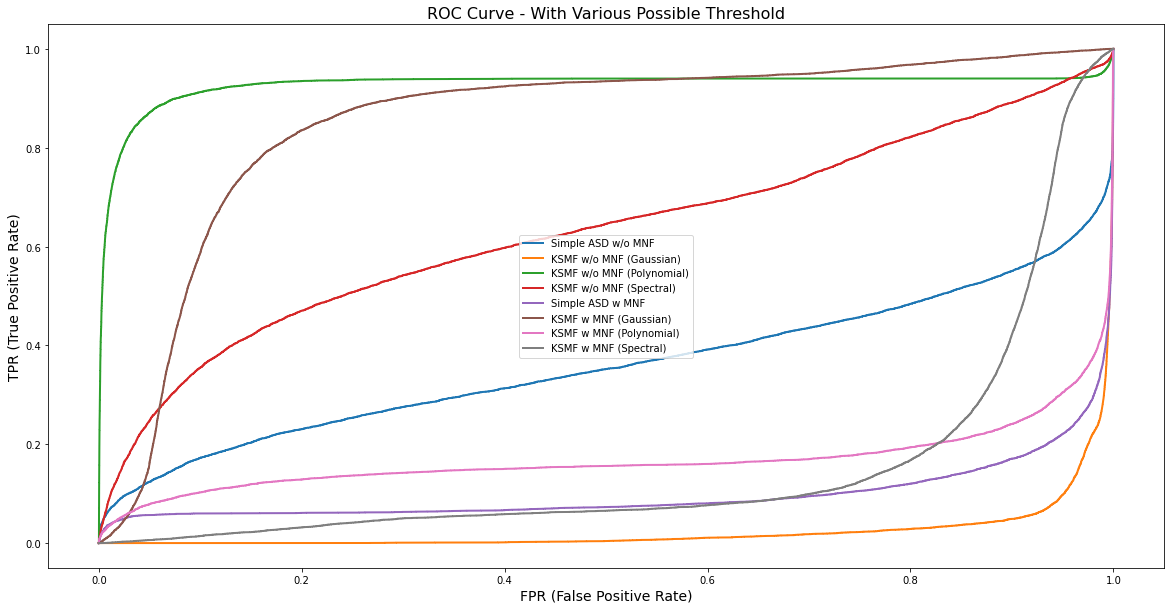

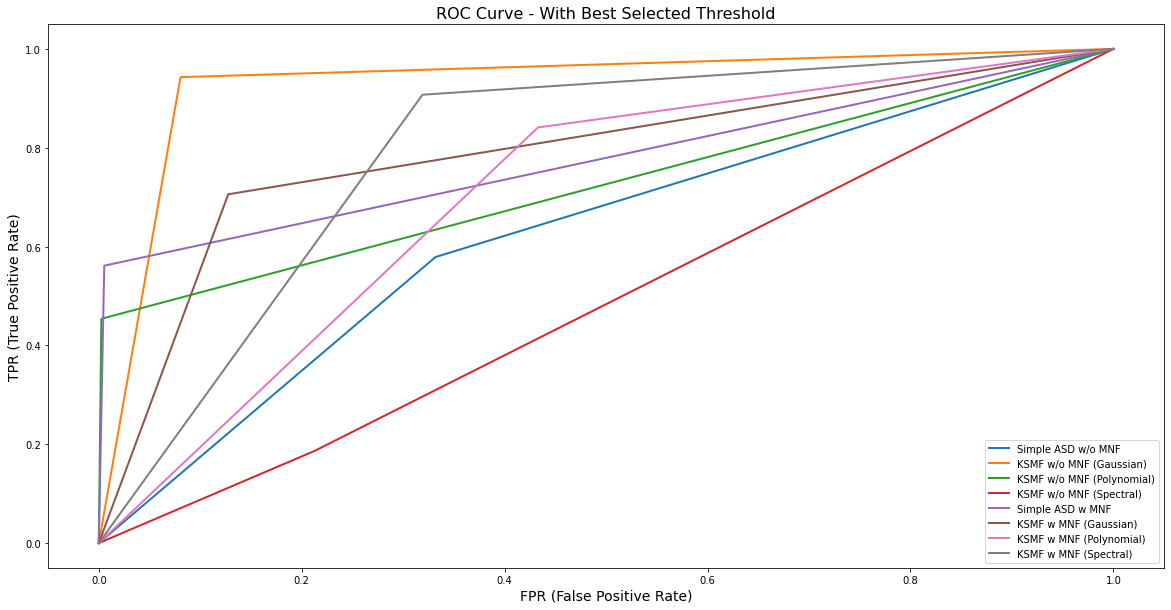

In [19]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)

# reload all pickle files for plotting 

with open("./kernel_data/y_MFD.pkl","rb") as f:
    y_MFD = pkl.load(f)
with open("./kernel_data/PREDS_MFD.pkl","rb") as f:
    PREDS_MFD = pkl.load(f)
with open("./kernel_data/GT_LABELS_MFD.pkl","rb") as f:
    GT_LABELS_MFD = pkl.load(f)
    
    
with open("./kernel_data/y_KSMF_Gaussian.pkl","rb") as f:
    y_KSMF_Gaussian = pkl.load(f)
with open("./kernel_data/PREDS_KSMF_Gaussian.pkl","rb") as f:
    PREDS_KSMF_Gaussian = pkl.load(f)
with open("./kernel_data/GT_LABELS_KSMF_Gaussian.pkl","rb") as f:
    GT_LABELS_KSMF_Gaussian = pkl.load(f)
    

with open("./kernel_data/y_KSMF_Polynomial.pkl","rb") as f:
    y_KSMF_Polynomial = pkl.load(f)
with open("./kernel_data/PREDS_KSMF_Polynomial.pkl","rb") as f:
    PREDS_KSMF_Polynomial = pkl.load(f)
with open("./kernel_data/GT_LABELS_KSMF_Polynomial.pkl","rb") as f:
    GT_LABELS_KSMF_Polynomial = pkl.load(f)
    
    
with open("./kernel_data/y_KSMF_Spectral.pkl","rb") as f:
    y_KSMF_Spectral = pkl.load(f)
with open("./kernel_data/PREDS_KSMF_Spectral.pkl","rb") as f:
    PREDS_KSMF_Spectral = pkl.load(f)
with open("./kernel_data/GT_LABELS_KSMF_Spectral.pkl","rb") as f:
    GT_LABELS_KSMF_Spectral = pkl.load(f)
    

    
with open("./kernel_data/y_MFD_MNF.pkl","rb") as f:
    y_MFD_MNF = pkl.load(f)
with open("./kernel_data/PREDS_MFD_MNF.pkl","rb") as f:
    PREDS_MFD_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_MFD_MNF.pkl","rb") as f:
    GT_LABELS_MFD_MNF = pkl.load(f)
    
    
with open("./kernel_data/y_KSMF_Gaussian_MNF.pkl","rb") as f:
    y_KSMF_Gaussian_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KSMF_Gaussian_MNF.pkl","rb") as f:
    PREDS_KSMF_Gaussian_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KSMF_Gaussian_MNF.pkl","rb") as f:
    GT_LABELS_KSMF_Gaussian_MNF = pkl.load(f)
    

with open("./kernel_data/y_KSMF_Polynomial_MNF.pkl","rb") as f:
    y_KSMF_Polynomial_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KSMF_Polynomial_MNF.pkl","rb") as f:
    PREDS_KSMF_Polynomial_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KSMF_Polynomial_MNF.pkl","rb") as f:
    GT_LABELS_KSMF_Polynomial_MNF = pkl.load(f)
    
    
with open("./kernel_data/y_KSMF_Spectral_MNF.pkl","rb") as f:
    y_KSMF_Spectral_MNF = pkl.load(f)
with open("./kernel_data/PREDS_KSMF_Spectral_MNF.pkl","rb") as f:
    PREDS_KSMF_Spectral_MNF = pkl.load(f)
with open("./kernel_data/GT_LABELS_KSMF_Spectral_MNF.pkl","rb") as f:
    GT_LABELS_KSMF_Spectral_MNF = pkl.load(f)

############################ Plot 1 - ROC Curve with Various Possible Thresholds #################################    
plt.figure(figsize=(20,10))

# using sklearn's roc_curve method to get FPR, TPR & Thresholds for each

# just a minot hack for y_MFD_MNF here as it was throwing some weird error with list type
GT_LABELS_MFD, y_MFD = np.array(GT_LABELS_MFD).reshape(-1,1), np.array(y_MFD).reshape(-1,1)
GT_LABELS_MFD_MNF, y_MFD_MNF = np.array(GT_LABELS_MFD_MNF).reshape(-1,1), np.array(y_MFD_MNF).reshape(-1,1)

fpr_MFD, tpr_MFD, _                              = roc_curve(GT_LABELS_MFD, y_MFD)
fpr_KSMF_Gaussian, tpr_KSMF_Gaussian, _          = roc_curve(GT_LABELS_KSMF_Gaussian, y_KSMF_Gaussian)
fpr_KSMF_Polynomial, tpr_KSMF_Polynomial, _      = roc_curve(GT_LABELS_KSMF_Polynomial, y_KSMF_Polynomial)
fpr_KSMF_Spectral, tpr_KSMF_Spectral,_ = roc_curve(GT_LABELS_KSMF_Spectral, y_KSMF_Spectral)

fpr_MFD_MNF, tpr_MFD_MNF, _                              = roc_curve(GT_LABELS_MFD_MNF, y_MFD_MNF)
fpr_KSMF_Gaussian_MNF, tpr_KSMF_Gaussian_MNF, _                  = roc_curve(GT_LABELS_KSMF_Gaussian_MNF, y_KSMF_Gaussian_MNF)
fpr_KSMF_Polynomial_MNF, tpr_KSMF_Polynomial_MNF, _      = roc_curve(GT_LABELS_KSMF_Polynomial_MNF, y_KSMF_Polynomial_MNF)
fpr_KSMF_Spectral_MNF, tpr_KSMF_Spectral_MNF,_ = roc_curve(GT_LABELS_KSMF_Spectral_MNF, y_KSMF_Spectral_MNF)

plot_roc_curve(fpr_MFD, tpr_MFD, label="Simple ASD w/o MNF ")
plot_roc_curve(fpr_KSMF_Gaussian, tpr_KSMF_Gaussian, label="KSMF w/o MNF (Gaussian)")
plot_roc_curve(fpr_KSMF_Polynomial, tpr_KSMF_Polynomial, label="KSMF w/o MNF (Polynomial)")
plot_roc_curve(fpr_KSMF_Spectral, tpr_KSMF_Spectral, label="KSMF w/o MNF (Spectral)")

plot_roc_curve(fpr_MFD_MNF, tpr_MFD_MNF, label="Simple ASD w MNF ")
plot_roc_curve(fpr_KSMF_Gaussian_MNF, tpr_KSMF_Gaussian_MNF, label="KSMF w MNF (Gaussian)")
plot_roc_curve(fpr_KSMF_Polynomial_MNF, tpr_KSMF_Polynomial_MNF, label="KSMF w MNF (Polynomial)")
plot_roc_curve(fpr_KSMF_Spectral_MNF, tpr_KSMF_Spectral_MNF, label="KSMF w MNF (Spectral)")

plt.xlabel("FPR (False Positive Rate)", size=14)
plt.ylabel("TPR (True Positive Rate)", size=14)
plt.legend()
plt.title("ROC Curve - With Various Possible Threshold", size=16)
plt.savefig("./pics/ROC_PossibleThresholds.png")
#############################################################################################################


# ############################ Plot 2 - ROC Curve with Best Selected Threshold During Testing Above #################################    
plt.figure(figsize=(20,10))
# using sklearn's roc_curve method to get FPR, TPR & Thresholds for each
fpr_MFD, tpr_MFD, _                              = roc_curve(GT_LABELS_MFD, PREDS_MFD)
fpr_KSMF_Gaussian, tpr_KSMF_Gaussian, _          = roc_curve(GT_LABELS_KSMF_Gaussian, PREDS_KSMF_Gaussian)
fpr_KSMF_Polynomial, tpr_KSMF_Polynomial, _      = roc_curve(GT_LABELS_KSMF_Polynomial, PREDS_KSMF_Polynomial)
fpr_KSMF_Spectral, tpr_KSMF_Spectral,_ = roc_curve(GT_LABELS_KSMF_Spectral, PREDS_KSMF_Spectral)

fpr_MFD_MNF, tpr_MFD_MNF, _                              = roc_curve(GT_LABELS_MFD_MNF, PREDS_MFD_MNF)
fpr_KSMF_Gaussian_MNF, tpr_KSMF_Gaussian_MNF, _                  = roc_curve(GT_LABELS_KSMF_Gaussian_MNF, PREDS_KSMF_Gaussian_MNF)
fpr_KSMF_Polynomial_MNF, tpr_KSMF_Polynomial_MNF, _      = roc_curve(GT_LABELS_KSMF_Polynomial_MNF, PREDS_KSMF_Polynomial_MNF)
fpr_KSMF_Spectral_MNF, tpr_KSMF_Spectral_MNF,_ = roc_curve(GT_LABELS_KSMF_Spectral_MNF, PREDS_KSMF_Spectral_MNF)



plot_roc_curve(fpr_MFD, tpr_MFD, label="Simple ASD w/o MNF ")
plot_roc_curve(fpr_KSMF_Gaussian, tpr_KSMF_Gaussian, label="KSMF w/o MNF (Gaussian)")
plot_roc_curve(fpr_KSMF_Polynomial, tpr_KSMF_Polynomial, label="KSMF w/o MNF (Polynomial)")
plot_roc_curve(fpr_KSMF_Spectral, tpr_KSMF_Spectral, label="KSMF w/o MNF (Spectral)")

plot_roc_curve(fpr_MFD_MNF, tpr_MFD_MNF, label="Simple ASD w MNF ")
plot_roc_curve(fpr_KSMF_Gaussian_MNF, tpr_KSMF_Gaussian_MNF, label="KSMF w MNF (Gaussian)")
plot_roc_curve(fpr_KSMF_Polynomial_MNF, tpr_KSMF_Polynomial_MNF, label="KSMF w MNF (Polynomial)")
plot_roc_curve(fpr_KSMF_Spectral_MNF, tpr_KSMF_Spectral_MNF, label="KSMF w MNF (Spectral)")

plt.xlabel("FPR (False Positive Rate)", size=14)
plt.ylabel("TPR (True Positive Rate)", size=14)
plt.legend()
plt.title("ROC Curve - With Best Selected Threshold", size=16)

plt.savefig("./pics/ROC_SelectedThreshold.png")
# #############################################################################################################